# Assignment 2 - Transient Conduction

Solve the following problem and explain your results.

## Problem 1 - Transient Conduction in a Plane Wall

The problem we consider is that of a plane wall initially at 100$^\circ$C with its outer surfaces exposed to an ambient temperature of 0$^\circ$C.  The wall has a thickness 2*L* and may be considered to have an infinite height and a unit depth. The domain is shown schematically below:

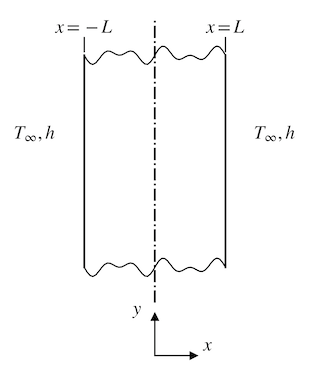

Initially, the wall only feels the effect of the ambient air very near the surface and thus, the temperature profile inside the solid is quite steep in the vicinity of the surface.  An analytical solution for this problem involves several (at least 4) terms of a Fourier series.  After some time, however, the influence of the ambient air will have reached the center of the wall and the analytical solution can be approximated by the first term of the Fourier series (see, for example, *Fundamentals of Heat and Mass Transfer* by Incropera et al.). To study the order of accuracy of the fully implicit first and second order time discretization schemes, we will consider the cooling process during a period past the initial transient where the one-term Fourier solution is valid.

The parameters for the problem are:

$$ Bi = \frac{h L}{k}= 1.0 $$

$$ T_i = 100^\circ C $$

$$ T_{\infty}= 0^\circ C $$

The one-term Fourier solution for this problem is:

$$
\frac{T-T_{\infty}}{T_i-T_{\infty}}=C_1 \exp\left(-\zeta^2\frac{\alpha t}{L^2}\right)\cos\left(\zeta \frac{x}{L}\right)
$$

where:

$$ T = T(x,t) $$

$$ \alpha = \frac{k}{\rho c_p} $$

$$ C_1 = 1.1191 $$

$$ \zeta = 0.8603 $$

The solution to this problem at the two different dimensionless time levels of interest is:

$$ \text{at } \frac{\alpha t_1}{L^2}= 0.4535,~~~ T(0,t_1)= 80^\circ C $$

$$ \text{at } \frac{\alpha t_2}{L^2}= 3.2632,~~~ T(0,t_2)= 10^\circ C $$

To solve this problem, initialize the temperature field using the analytical solution at $\alpha t_1/L^2 = 0.4535$. This avoids the need for a very small timestep during the initial transient when solution is changing rapidly. Then, use your code to calculate the temporal variation of the temperature field over the time period described above.  Solve the problem by employing 2, 4, 8, 16, and 32 time steps using both the first and second order implicit schemes.

At the end of each run, calculate the absolute average error, $\overline{e}$, using the formula:

$$
\overline{e}= \frac{1}{N_{CV}} \sum_{i=1}^{N_{CV}} |e(i)|
$$

where

$$ e(i) = T_{exact}(i) - T(i) $$ 

Then, for each scheme, plot your results of $\overline{e}$ vs. $\Delta t$ (on a log-log scale) and find the value of $p$ in the expression:

$$
\overline{e}= c (\Delta t)^p
$$

where $p$ represents the order accuracy of the transient scheme. Also show a separate plot of T(0,$t_2$) verses the number of timesteps used for each scheme employed.

Repeat this problem on at least three different grids to demonstrate grid independence of the solution.

**Bonus**: Solve the same problem using the Crank-Nicolson scheme and compare the results.


# Class definition


In [88]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in x-direction [m]
            lz .... total length of domain in x-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])

        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)

        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)

        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol



In [89]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP



In [90]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")
class RobinBc:
    """Class defining a Robin boundary condition"""
    
    def __init__(self, phi, grid, h, k, Tamb, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            h........... convection coefficient
            k........... thermal conductivity 
            Tamb........ ambient temperature
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._h = h
        self._k = k
        self._Tamb = Tamb
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1/(1+((self._h/self._k)*self._grid.dx_WP[0])))
        elif self._loc is BoundaryLocation.EAST:
            return (1/(1+((self._h/self._k)*self._grid.dx_PE[-1])))
      
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")


In [91]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs

class SurfaceConvectionModel:
    """Class defining a surface convection model"""

    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To

    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""

        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)

        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)

        return coeffs



In [92]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)



In [93]:
class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transientterm = self._rho * self._cp * self._grid.vol * ((self._T[1:-1]-self._Told[1:-1])/self._dt)
        
        # Calculate the linearization coefficient
        coeffP = (self._rho * self._cp * self._grid.vol)/self._dt
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(transientterm)
        return coeffs
    

# First order implicit scheme

## Grid Independence test with different number of control volumes
### 5 control volumes

In [94]:
""" Case 1 : Specification and computation with 5 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T5 = T_solns[-1]  
xP5 = grid.xP
diff_5 = T_final-T5
print('Difference between Analytical & Numerical solution at final timestep',diff_5)
e_5 = sum(diff_5) / len(diff_5)
print('Absolute average error = ',abs(e_5))

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 11.76928738102262; Avg. Resid. = 10.399272829619466
Iteration = 1; Max. Resid. = 7.105427357601002e-14; Avg. Resid. = 4.991562718714704e-14
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 11.048232268882428; Avg. Resid. = 9.769603229165416
Iteration = 1; Max. Resid. = 3.552713678800501e-14; Avg. Resid. = 1.8118839761882553e-14
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 10.371334901524063; Avg. Resid. = 9.176771378512472
Iteration = 1; Max. Resid. = 8.348877145181177e-14; Avg. Resid. = 5.3290705182007514e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 9.737400244170756; Avg. Resid. = 8.61944419258734
Iteration = 1; Max. Resid. = 5.684341886080802e-14; Avg. Resid. = 3.4283687000424835e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 9.14351750204627; Avg. Resid. = 8.095764838395697
Iteration = 1; Max. Resid. = 4.263256414560601e-14; Av

### 10 control volumes

In [95]:
""" Case 1 : Specification and computation with 10 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T10 = T_solns[-1]  
xP10 = grid.xP
diff_10 = T_final-T10
print('Difference between Analytical & Numerical solution at final timestep',diff_10)
e_10 = sum(diff_10) / len(diff_10)
print('Absolute average error = ',abs(e_10))

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.2967404927621828e-13; Avg. Resid. = 5.4489746048602684e-14
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 5.550965374285538; Avg. Resid. = 4.895658616423641
Iteration = 1; Max. Resid. = 7.815970093361102e-14; Avg. Resid. = 3.947953075567057e-14
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 5.211970986605933; Avg. Resid. = 4.59732236947121
Iteration = 1; Max. Resid. = 1.0746958878371515e-13; Avg. Resid. = 5.2891024893142455e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 4.893831469855882; Avg. Resid. = 4.3171072167754225
Iteration = 1; Max. Resid. = 8.43769498715119e-14; Avg. Resid. = 4.2943426592501056e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 4.5952586216623095; Avg. Resid. = 4.053948487395669
Iteration = 1; Max. Resid. = 1.3633538742396922e-13; A

### 20 control volumes

In [96]:
""" Case 1 : Specification and computation with 20 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T20 = T_solns[-1]  
xP20 = grid.xP
diff_20 = T_final-T20
print('Difference between Analytical & Numerical solution at final timestep',diff_20)
e_20 = sum(diff_20) / len(diff_20)
print('Absolute average error  = ',abs(e_20))

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 4.525269048372138e-13; Avg. Resid. = 1.7942314300967154e-13
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 2.7788248003946587; Avg. Resid. = 2.449197182689724
Iteration = 1; Max. Resid. = 4.2588155224621005e-13; Avg. Resid. = 1.1055600879217308e-13
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 2.609265765458701; Avg. Resid. = 2.2997812798156128
Iteration = 1; Max. Resid. = 4.001243780749064e-13; Avg. Resid. = 8.745226764972359e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 2.4500598868954166; Avg. Resid. = 2.1594778000266297
Iteration = 1; Max. Resid. = 1.8740564655672642e-13; Avg. Resid. = 8.754108549169359e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 2.3005749532489967; Avg. Resid. = 2.0277327675654746
Iteration = 1; Max. Resid. = 2.424727085781342

### 30 control volumes

In [97]:
""" Case 1 : Specification and computation with 30 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T30 = T_solns[-1]  
xP30 = grid.xP
diff_30 = T_final-T30
print('Difference between Analytical & Numerical solution at final timestep',diff_30)
e_30 = sum(diff_30) / len(diff_30)
print('Absolute average error  = ',abs(e_30))

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 1.9733555023861977; Avg. Resid. = 1.7390917070986154
Iteration = 1; Max. Resid. = 6.621370118864434e-13; Avg. Resid. = 2.089513747212853e-13
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 1.8529620611465698; Avg. Resid. = 1.6329673215392462
Iteration = 1; Max. Resid. = 5.935252289646087e-13; Avg. Resid. = 1.5267787034645153e-13
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 1.7399152467274344; Avg. Resid. = 1.533325884303457
Iteration = 1; Max. Resid. = 4.4209080840573733e-13; Avg. Resid. = 1.5421737960726507e-13
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 1.633761505278528; Avg. Resid. = 1.4397659927089193
Iteration = 1; Max. Resid. = 2.6689761511988763e-13; Avg. Resid. = 8.337774914934926e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 1.534080539673681; Avg. Resid. = 1.3519154966833091
Iteration = 1; Max. Resid. = 3.645972412869014e

### Plot for Grid convergence test

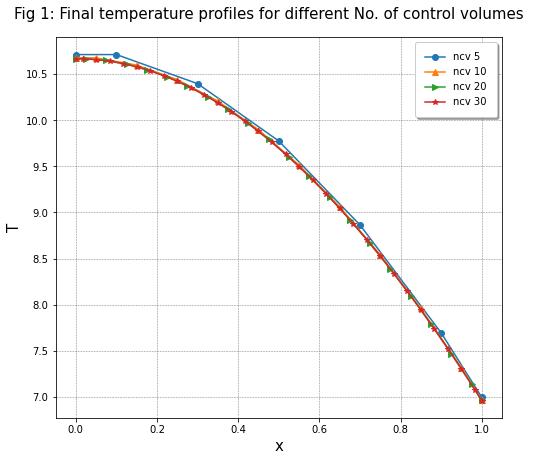

In [98]:
""" Plot for testing Grid convergence """
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize =(8,7))

plt.plot(xP5, T5 , marker = "o", label = "ncv 5")
plt.plot(xP10, T10, marker = "^", label = "ncv 10")
plt.plot(xP20, T20, marker = ">", label = "ncv 20")
plt.plot(xP30, T30, marker = "*",label = "ncv 30")


plt.xlabel('x',fontsize = 15)
plt.ylabel('T',fontsize = 15)
plt.suptitle('Fig 1: Final temperature profiles for different No. of control volumes ', fontsize=15,y=0.94)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

### Comments on the grid convergence test :
Starting from 5 control volumes, we went upto to taking 30 control volumes in half of the plane wall (From x=0 to x=L) for discretion of the field equation. The numerical solution for all 4 cases i.e. 5,10,20 and 30 control volumes show very close temperature profiles as shown in the graph above. But beyong 10 control volumes, the numerical solution curves overlap, so considering the graph only, we can say that 10 control volumes are sufficient for solving this problem. 

To dig deeper into the accuracy of solutions for each case, we also calculated the difference between the numerical solution and analytical solution at each internal control volume. The one-term fourier analytical solution of the problem is given by :
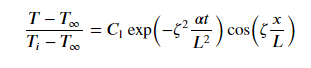
It was observed that, for the first case (ncv=5), the average error in the temperature values at the final timestep is  0.646 and as we increase the number of control volumes to 10,20 and 30, the average error becomes 0.6004,0.5896,0.5881 respectively. So we can say that, beyond 20 control volumes the Analytical & Numerical solutions at the final timestep match upto 2 decimal digits. 

Thus, judging from the graph and comparison with the analytical solution, it is safe to conclude that 20 control volumes are sufficient for discretizing the problem to get upto 2 digits of accuracy. 


## Temporal discretization with different time step sizes

##  2 timesteps

In [113]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_2 = T_solns[-1]
dt2 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_2)
ei_2 = T_final[1:-1]- T_2[1:-1]
e_2 = sum(ei_2) / len(ei_2) # Where len(ei_2) = ncv
print('Absolute average error = ',abs(e_2))

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 2.90656387846866e-13; Avg. Resid. = 1.2004841565271817e-13
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 1.4509565669382594; Avg. Resid. = 1.278874519950752
Iteration = 1; Max. Resid. = 1.6686652060116103e-13; Avg. Resid. = 5.400124791776761e-14
[19.22771853 19.22771853 19.19214835 19.12107379 19.01462633 18.87300291
 18.69646552 18.48534075 18.24001916 17.9609546  17.64866333 17.30372306
 16.92677193 16.51850728 16.07968437 15.61111502 15.11366605 14.58825772
 14.035862   13.45750081 12.85424407 12.54072592]
Analytical Final Temperature field = [9.9996306  9.99731791 9.97882282 9.94186686 9.8865184  9.81287983
 9.72108738 9.61131088 9.4837534  9.33865093 9.17627191 8.99691674
 8.80091723 8.58863599 8.36046572 8.11682855 7.8581752  7.5849842
 7.29776093 6.99703677 6.68336806 6.52185993]
Difference between Analytical & Numerical solution 

##  4 timesteps

In [114]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
dt = 0.702425
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_4 = T_solns[-1]
dt4 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_4)
ei_4 = T_final[1:-1]- T_4[1:-1]
e_4 = sum(ei_4) / len(ei_4) # Where len(ei_4) = ncv
print('Absolute average error = ',abs(e_4))

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 4.4786396813378815e-13; Avg. Resid. = 1.7081891456882658e-13
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 1.9472025671866784; Avg. Resid. = 1.7162606277107304
Iteration = 1; Max. Resid. = 2.4069635173873394e-13; Avg. Resid. = 8.629763570411341e-14
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 1.28123104200597; Avg. Resid. = 1.129285082892825
Iteration = 1; Max. Resid. = 1.6464607455191071e-13; Avg. Resid. = 6.254996520738132e-14
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 0.8430369352809207; Avg. Resid. = 0.7430593772413934
Iteration = 1; Max. Resid. = 6.128431095930864e-14; Avg. Resid. = 3.2077118738982337e-14
[14.99264957 14.99264957 14.96491404 14.90949431 14.82649289 14.71606332
 14.57840991 14.41378729 14.22250001 14.00490194 13.76139563 13.49243154
 13.19850725

##  8 Timesteps


In [115]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
dt = 0.351213
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_8 = T_solns[-1]
dt8 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_8)
ei_8 = T_final[1:-1]- T_8[1:-1]
e_8 = sum(ei_8) / len(ei_8) # Where len(ei_8) = ncv
print('Absolute average error = ',abs(e_8))

Timestep = 0; Time = 0.804713
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 2.7755575615628914e-13; Avg. Resid. = 1.003530591958679e-13
Timestep = 1; Time = 1.155926
Iteration = 0; Max. Resid. = 2.3488805159220756; Avg. Resid. = 2.0702875945901345
Iteration = 1; Max. Resid. = 2.191580250610059e-13; Avg. Resid. = 1.0413891970983968e-13
Timestep = 2; Time = 1.507139
Iteration = 0; Max. Resid. = 1.8643350318943415; Avg. Resid. = 1.6432322834835902
Iteration = 1; Max. Resid. = 2.262634524186069e-13; Avg. Resid. = 6.604161661982744e-14
Timestep = 3; Time = 1.858352
Iteration = 0; Max. Resid. = 1.4797561895659326; Avg. Resid. = 1.3042675910740347
Iteration = 1; Max. Resid. = 1.580957587066223e-13; Avg. Resid. = 6.027400800689975e-14
Timestep = 4; Time = 2.209565
Iteration = 0; Max. Resid. = 1.1745118101844552; Avg. Resid. = 1.0352239992458971
Iteration = 1; Max. Resid. = 9.958700530887654e-14; Avg. Resid. = 4.1622261193197116e-

##  16 Timesteps

In [116]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
dt = 0.175606
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_16 = T_solns[-1]
dt16 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_16)
ei_16 = T_final[1:-1]- T_16[1:-1]
e_16 = sum(ei_16) / len(ei_16) # Where len(ei_16) = ncv
print('Absolute average error = ',abs(e_16))

Timestep = 0; Time = 0.629106
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 4.3876013933186186e-13; Avg. Resid. = 1.300848317953296e-13
Timestep = 1; Time = 0.8047120000000001
Iteration = 0; Max. Resid. = 2.6190222672940418; Avg. Resid. = 2.3083708628853197
Iteration = 1; Max. Resid. = 2.8044233602031454e-13; Avg. Resid. = 7.392975120978917e-14
Timestep = 2; Time = 0.9803180000000001
Iteration = 0; Max. Resid. = 2.3178052583588733; Avg. Resid. = 2.0429109722487127
Iteration = 1; Max. Resid. = 2.3936408410918375e-13; Avg. Resid. = 1.0125233984581428e-13
Timestep = 3; Time = 1.1559240000000002
Iteration = 0; Max. Resid. = 2.051244458731247; Avg. Resid. = 1.8079761334531448
Iteration = 1; Max. Resid. = 2.3381296898605797e-13; Avg. Resid. = 1.006972283335017e-13
Timestep = 4; Time = 1.33153
Iteration = 0; Max. Resid. = 1.815345796362919; Avg. Resid. = 1.6000581174412987
Iteration = 1; Max. Resid. = 1.5210055437364645e-13; Avg

##  32 Timesteps

In [117]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final_32 = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final_32[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final_32)
T_32 = T_solns[-1]
dt32 = dt
xP = grid.xP
print('Difference between Analytical & Numerical solution at final timestep ',T_final_32- T_32)
ei_32 = T_final_32[1:-1]- T_32[1:-1]
e_32 = sum(ei_32) / len(ei_32) # Where len(ei_32) = ncv
print('Absolute average error = ',abs(e_32))


Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 4.525269048372138e-13; Avg. Resid. = 1.7942314300967154e-13
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 2.7788248003946587; Avg. Resid. = 2.449197182689724
Iteration = 1; Max. Resid. = 4.2588155224621005e-13; Avg. Resid. = 1.1055600879217308e-13
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 2.609265765458701; Avg. Resid. = 2.2997812798156128
Iteration = 1; Max. Resid. = 4.001243780749064e-13; Avg. Resid. = 8.745226764972359e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 2.4500598868954166; Avg. Resid. = 2.1594778000266297
Iteration = 1; Max. Resid. = 1.8740564655672642e-13; Avg. Resid. = 8.754108549169359e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 2.3005749532489967; Avg. Resid. = 2.0277327675654746
Iteration = 1; Max. Resid. = 2.424727085781342

## Plot of Final temperature profile for different number of timesteps

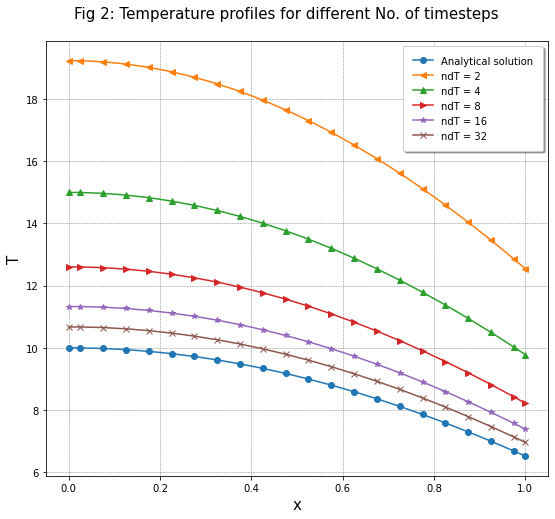

In [118]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize =(9,8))

plt.plot(xP,T_final_32,marker = "o",label = "Analytical solution")
plt.plot(xP, T_2 , marker = "<", label = "ndT = 2")
plt.plot(xP, T_4, marker = "^", label = "ndT = 4")
plt.plot(xP, T_8, marker = ">", label = "ndT = 8")
plt.plot(xP, T_16, marker = "*",label = "ndT = 16")
plt.plot(xP, T_32, marker = "x",label = "ndT = 32")

plt.xlabel('x',fontsize = 15)
plt.ylabel('T',fontsize = 15)
plt.suptitle('Fig 2: Temperature profiles for different No. of timesteps ', fontsize=15,y=0.94)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

## Plot of absolute average error vs timestep size

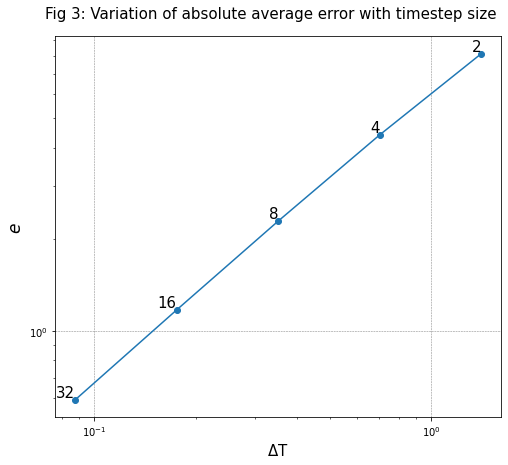

Order of Accuracy of the First order transient scheme = 1.299862919150922


In [119]:
""" Plot for testing temporal discretization error  """
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.figure(figsize =(8,7))

errors = [abs(e_2), abs(e_4), abs(e_8), abs(e_16),abs(e_32)]
timesteps = [dt2, dt4, dt8, dt16, dt32]

plt.loglog(timesteps, errors , marker = "o")

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)
# Fit the dummy exponential data
pars, cov = curve_fit(f=exponential, xdata=timesteps, ydata=errors, p0=[0, 0], bounds=(-np.inf, np.inf))
c = pars[1]
p = pars [-1]

plt.xlabel((r'$\Delta $T'),fontsize = 15)
plt.ylabel((r'$e$'),fontsize = 17)
plt.suptitle('Fig 3: Variation of absolute average error with timestep size', fontsize=15,y=0.94)
n = [2, 4, 8, 16, 32]

for i, txt in enumerate(n):
    plt.annotate(txt, (timesteps[i], errors[i]),fontsize=15, ha='right', va='bottom')

plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()
print('Order of Accuracy of the First order transient scheme =',p)

## Comments of error variation with timestep size

In $Fig.2$ we have plotted the temperature profile at final time (3.2632 second) over half of the plane wall (from x=0 to x=L) for different number of timesteps. It is observed that, the temperature profile for 32 timesteps with $\Delta $T = 0.087803 is the closest to the Analytical solution and the temperature profile for 2 timesteps with $\Delta $T = 1.40485 is the farthest. This indicates that, more the number of timesteps we use i.e. smaller the timestep size, better will be the accuracy of the solution.

In $Fig.3$, we have plotted the absolute average error vs the time step size for first order transient scheme and fitted an exponential curve on the log-log plot to obtain the exponent $p$ in $e$ = $c(\Delta T)^{p}$ as 1.29 which rounds to 1. Thus, our plot supports the conclusion that First order transient scheme is 1st order accurate .

## Plot of T(0,t2) vs Number of timesteps

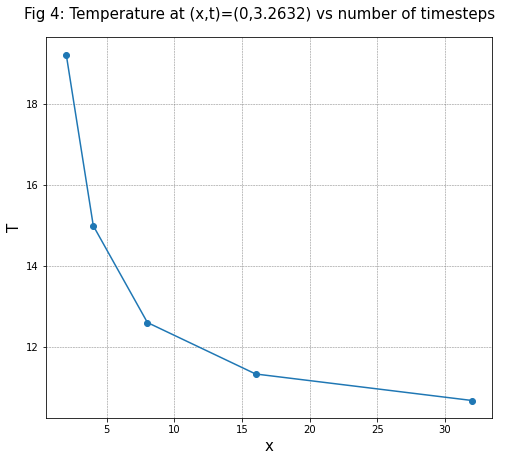

In [120]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize =(8,7))

xarray = [2,4,8,16,32]
yarray = [T_2[1],T_4[1],T_8[1],T_16[1],T_32[1] ]

plt.plot(xarray, yarray , marker = "o")

plt.xlabel('x',fontsize = 15)
plt.ylabel('T',fontsize = 15)
plt.suptitle('Fig 4: Temperature at (x,t)=(0,3.2632) vs number of timesteps ', fontsize=15,y=0.94)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

From the Analytical solution we know that at x=0 at the final timestep i.e. $t_{2}$ = 3.2632 second, the temperature should be 10 [$^\circ$C]. When we divide the time interval into 2 timesteps only, then we obtaint T(0,$t_{2}$) = 19.22 [$^\circ$C]. Then as we increase the number of timesteps to 4,8,16 and finally 32 we get T(0,$t_{2}$) = 14.993, 12.599, 11.326 and 10.67 [$^\circ$C] respectively. Thus when the time interval is divided into 32 timesteps, the temperature at the centerline of the plane wall at the end of simulation is closest to the analytical temperature. 

# Second order implicit scheme

## Class definition

In [107]:
class SecondOrderTransientModel:
    """Class defining a Second order implicit transient model"""

    def __init__(self, grid, T, Told, Tolder, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._Tolder = Tolder
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transientterm = self._rho * self._cp * self._grid.vol * (( ((3/2)*self._T[1:-1]) - (2*self._Told[1:-1]) + ((1/2)*self._Tolder[1:-1]) )/self._dt)
        
        # Calculate the linearization coefficient
        coeffP = (3/2)* ((self._rho * self._cp * self._grid.vol)/self._dt)
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(transientterm)
        return coeffs
    

## Grid Independence test with different number of control volumes
### 5 control volumes

[80.00205565 79.70618416 77.35232668 72.7141251  65.92855328 57.19600056
 52.1781476 ]
[79.70618416 79.70618416 77.35232668 72.7141251  65.92855328 57.19600056
 51.99636415]
Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 11.769287381022636; Avg. Resid. = 10.39927282961946
Iteration = 1; Max. Resid. = 8.526512829121202e-14; Avg. Resid. = 6.608047442568932e-14
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 15.03832318419767; Avg. Resid. = 13.29496815054408
Iteration = 1; Max. Resid. = 7.993605777301127e-14; Avg. Resid. = 5.577760475716786e-14
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 19.213819850829402; Avg. Resid. = 16.995245861756434
Iteration = 1; Max. Resid. = 9.947598300641403e-14; Avg. Resid. = 4.085620730620576e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 24.55001581151589; Avg. Resid. = 21.724399582885145
Iteration = 1; Max. Resid. = 1.9539925233402755e-14; Avg. Resid. = 1.3145040611561854e-1

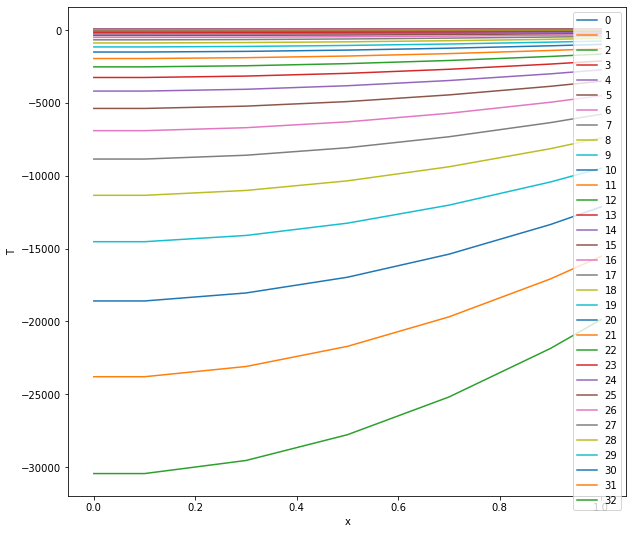

In [112]:
""" Case 1 : Specification and computation with 5 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

print(T)
# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()
print(T)

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Tolder = np.copy(Told)
transient = SecondOrderTransientModel(grid, T, Told, Tolder, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Tolder = Told[:]
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T5 = T_solns[-1]  
xP5 = grid.xP
diff_5 = T_final-T5
print('Difference between Analytical & Numerical solution at final timestep',diff_5)
e_5 = sum(diff_5) / len(diff_5)
print('Absolute average error = ',abs(e_5))


%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize =(10,9))

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

### 10 control volumes

In [49]:
""" Case 1 : Specification and computation with 10 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Tolder = np.copy(Told)
transient = SecondOrderTransientModel( grid, T, Told, Tolder, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T10 = T_solns[-1]  
xP10 = grid.xP
diff_10 = T_final-T10
print('Difference between Analytical & Numerical solution at final timestep',diff_10)
e_10 = sum(diff_10) / len(diff_10)
print('Absolute average error = ',abs(e_10))

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.0835776720341528e-13; Avg. Resid. = 6.212808045802376e-14
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 7.555104633145986; Avg. Resid. = 6.662876421354648
Iteration = 1; Max. Resid. = 1.3233858453531866e-13; Avg. Resid. = 9.747758156208874e-14
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 9.65471587560662; Avg. Resid. = 8.51550780506038
Iteration = 1; Max. Resid. = 1.6253665080512292e-13; Avg. Resid. = 6.425970866530406e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 12.337922161474769; Avg. Resid. = 10.883136865513169
Iteration = 1; Max. Resid. = 7.37188088351104e-14; Avg. Resid. = 3.561595462997502e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 15.76714995104198; Avg. Resid. = 13.908977082383206
Iteration = 1; Max. Resid. = 1.4432899320127035e-13; Avg

### 20 control volumes

In [292]:
""" Case 1 : Specification and computation with 20 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T20 = T_solns[-1]  
xP20 = grid.xP
diff_20 = T_final-T20
print('Difference between Analytical & Numerical solution at final timestep',diff_20)
e_20 = sum(diff_20) / len(diff_20)
print('Absolute average error  = ',abs(e_20))

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 4.525269048372138e-13; Avg. Resid. = 1.7942314300967154e-13
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 2.7788248003946587; Avg. Resid. = 2.449197182689724
Iteration = 1; Max. Resid. = 4.2588155224621005e-13; Avg. Resid. = 1.1055600879217308e-13
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 2.609265765458701; Avg. Resid. = 2.2997812798156128
Iteration = 1; Max. Resid. = 4.001243780749064e-13; Avg. Resid. = 8.745226764972359e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 2.4500598868954166; Avg. Resid. = 2.1594778000266297
Iteration = 1; Max. Resid. = 1.8740564655672642e-13; Avg. Resid. = 8.754108549169359e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 2.3005749532489967; Avg. Resid. = 2.0277327675654746
Iteration = 1; Max. Resid. = 2.424727085781342

### 30 control volumes

In [293]:
""" Case 1 : Specification and computation with 30 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T30 = T_solns[-1]  
xP30 = grid.xP
diff_30 = T_final-T30
print('Difference between Analytical & Numerical solution at final timestep',diff_30)
e_30 = sum(diff_30) / len(diff_30)
print('Absolute average error  = ',abs(e_30))

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 1.9733555023861977; Avg. Resid. = 1.7390917070986154
Iteration = 1; Max. Resid. = 6.621370118864434e-13; Avg. Resid. = 2.089513747212853e-13
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 1.8529620611465698; Avg. Resid. = 1.6329673215392462
Iteration = 1; Max. Resid. = 5.935252289646087e-13; Avg. Resid. = 1.5267787034645153e-13
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 1.7399152467274344; Avg. Resid. = 1.533325884303457
Iteration = 1; Max. Resid. = 4.4209080840573733e-13; Avg. Resid. = 1.5421737960726507e-13
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 1.633761505278528; Avg. Resid. = 1.4397659927089193
Iteration = 1; Max. Resid. = 2.6689761511988763e-13; Avg. Resid. = 8.337774914934926e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 1.534080539673681; Avg. Resid. = 1.3519154966833091
Iteration = 1; Max. Resid. = 3.645972412869014e

### Plot for Grid convergence test

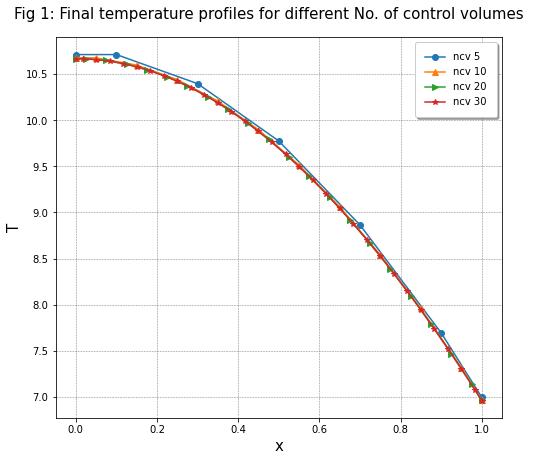

In [295]:
""" Plot for testing Grid convergence """
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize =(8,7))

plt.plot(xP5, T5 , marker = "o", label = "ncv 5")
plt.plot(xP10, T10, marker = "^", label = "ncv 10")
plt.plot(xP20, T20, marker = ">", label = "ncv 20")
plt.plot(xP30, T30, marker = "*",label = "ncv 30")


plt.xlabel('x',fontsize = 15)
plt.ylabel('T',fontsize = 15)
plt.suptitle('Fig 1: Final temperature profiles for different No. of control volumes ', fontsize=15,y=0.94)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

### Comments on the grid convergence test :
Starting from 5 control volumes, we went upto to taking 30 control volumes in half of the plane wall (From x=0 to x=L) for discretion of the field equation. The numerical solution for all 4 cases i.e. 5,10,20 and 30 control volumes show very close temperature profiles as shown in the graph above. But beyong 10 control volumes, the numerical solution curves overlap, so considering the graph only, we can say that 10 control volumes are sufficient for solving this problem. 

To dig deeper into the accuracy of solutions for each case, we also calculated the difference between the numerical solution and analytical solution at each internal control volume. The one-term fourier analytical solution of the problem is given by :
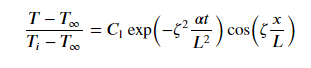
It was observed that, for the first case (ncv=5), the average error in the temperature values at the final timestep is  0.646 and as we increase the number of control volumes to 10,20 and 30, the average error becomes 0.6004,0.5896,0.5881 respectively. So we can say that, beyond 20 control volumes the Analytical & Numerical solutions at the final timestep match upto 2 decimal digits. 

Thus, judging from the graph and comparison with the analytical solution, it is safe to conclude that 20 control volumes are sufficient for discretizing the problem to get upto 2 digits of accuracy. 


## Temporal discretization with different time step sizes

##  2 timesteps

In [296]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Initial Temperature field =',T)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()
print(T)

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_2 = T_solns[-1]
dt2 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_2)
ei_2 = T_final[1:-1]- T_2[1:-1]
e_2 = sum(ei_2) / len(ei_2) # Where len(ei_2) = ncv
print('Absolute average error = ',abs(e_2))

Initial Temperature field = [80.00205565 79.98355299 79.83558302 79.53991683 79.0971014  78.50795594
 77.77357037 76.89530331 75.87477957 74.7138871  73.41477358 71.97984236
 70.41174807 68.7133917  66.88791522 64.93869577 62.86933941 60.68367445
 58.38574441 55.97980044 53.47029357 52.1781476 ]
[79.98355299 79.98355299 79.83558302 79.53991683 79.0971014  78.50795594
 77.77357037 76.89530331 75.87477957 74.7138871  73.41477358 71.97984236
 70.41174807 68.7133917  66.88791522 64.93869577 62.86933941 60.68367445
 58.38574441 55.97980044 53.47029357 52.16614007]
Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 2.90656387846866e-13; Avg. Resid. = 1.2004841565271817e-13
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 1.4509565669382594; Avg. Resid. = 1.278874519950752
Iteration = 1; Max. Resid. = 1.6686652060116103e-13; Avg. Resid. = 5.400124791776761e-14
[19.22771853 19.22771853 19.19214835 

##  4 timesteps

In [297]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
dt = 0.702425
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Initial Temperature field =',T)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()
print(T)

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_4 = T_solns[-1]
dt4 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_4)
ei_4 = T_final[1:-1]- T_4[1:-1]
e_4 = sum(ei_4) / len(ei_4) # Where len(ei_4) = ncv
print('Absolute average error = ',abs(e_4))

Initial Temperature field = [80.00205565 79.98355299 79.83558302 79.53991683 79.0971014  78.50795594
 77.77357037 76.89530331 75.87477957 74.7138871  73.41477358 71.97984236
 70.41174807 68.7133917  66.88791522 64.93869577 62.86933941 60.68367445
 58.38574441 55.97980044 53.47029357 52.1781476 ]
[79.98355299 79.98355299 79.83558302 79.53991683 79.0971014  78.50795594
 77.77357037 76.89530331 75.87477957 74.7138871  73.41477358 71.97984236
 70.41174807 68.7133917  66.88791522 64.93869577 62.86933941 60.68367445
 58.38574441 55.97980044 53.47029357 52.16614007]
Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 4.4786396813378815e-13; Avg. Resid. = 1.7081891456882658e-13
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 1.9472025671866784; Avg. Resid. = 1.7162606277107304
Iteration = 1; Max. Resid. = 2.4069635173873394e-13; Avg. Resid. = 8.629763570411341e-14
Timestep = 

##  8 Timesteps


In [298]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
dt = 0.351213
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Initial Temperature field =',T)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()
print(T)

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_8 = T_solns[-1]
dt8 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_8)
ei_8 = T_final[1:-1]- T_8[1:-1]
e_8 = sum(ei_8) / len(ei_8) # Where len(ei_8) = ncv
print('Absolute average error = ',abs(e_8))

Initial Temperature field = [80.00205565 79.98355299 79.83558302 79.53991683 79.0971014  78.50795594
 77.77357037 76.89530331 75.87477957 74.7138871  73.41477358 71.97984236
 70.41174807 68.7133917  66.88791522 64.93869577 62.86933941 60.68367445
 58.38574441 55.97980044 53.47029357 52.1781476 ]
[79.98355299 79.98355299 79.83558302 79.53991683 79.0971014  78.50795594
 77.77357037 76.89530331 75.87477957 74.7138871  73.41477358 71.97984236
 70.41174807 68.7133917  66.88791522 64.93869577 62.86933941 60.68367445
 58.38574441 55.97980044 53.47029357 52.16614007]
Timestep = 0; Time = 0.804713
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 2.7755575615628914e-13; Avg. Resid. = 1.003530591958679e-13
Timestep = 1; Time = 1.155926
Iteration = 0; Max. Resid. = 2.3488805159220756; Avg. Resid. = 2.0702875945901345
Iteration = 1; Max. Resid. = 2.191580250610059e-13; Avg. Resid. = 1.0413891970983968e-13
Timestep = 2; Time = 1.507139
It

##  16 Timesteps

In [299]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
dt = 0.175606
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Initial Temperature field =',T)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()
print(T)

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_16 = T_solns[-1]
dt16 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_16)
ei_16 = T_final[1:-1]- T_16[1:-1]
e_16 = sum(ei_16) / len(ei_16) # Where len(ei_16) = ncv
print('Absolute average error = ',abs(e_16))

Initial Temperature field = [80.00205565 79.98355299 79.83558302 79.53991683 79.0971014  78.50795594
 77.77357037 76.89530331 75.87477957 74.7138871  73.41477358 71.97984236
 70.41174807 68.7133917  66.88791522 64.93869577 62.86933941 60.68367445
 58.38574441 55.97980044 53.47029357 52.1781476 ]
[79.98355299 79.98355299 79.83558302 79.53991683 79.0971014  78.50795594
 77.77357037 76.89530331 75.87477957 74.7138871  73.41477358 71.97984236
 70.41174807 68.7133917  66.88791522 64.93869577 62.86933941 60.68367445
 58.38574441 55.97980044 53.47029357 52.16614007]
Timestep = 0; Time = 0.629106
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 4.3876013933186186e-13; Avg. Resid. = 1.300848317953296e-13
Timestep = 1; Time = 0.8047120000000001
Iteration = 0; Max. Resid. = 2.6190222672940418; Avg. Resid. = 2.3083708628853197
Iteration = 1; Max. Resid. = 2.8044233602031454e-13; Avg. Resid. = 7.392975120978917e-14
Timestep = 2; Time = 0

##  32 Timesteps

In [300]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Initial Temperature field =',T)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()
print(T)

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final_32 = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final_32[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final_32)
T_32 = T_solns[-1]
dt32 = dt
xP = grid.xP
print('Difference between Analytical & Numerical solution at final timestep ',T_final_32- T_32)
ei_32 = T_final_32[1:-1]- T_32[1:-1]
e_32 = sum(ei_32) / len(ei_32) # Where len(ei_32) = ncv
print('Absolute average error = ',abs(e_32))


Initial Temperature field = [80.00205565 79.98355299 79.83558302 79.53991683 79.0971014  78.50795594
 77.77357037 76.89530331 75.87477957 74.7138871  73.41477358 71.97984236
 70.41174807 68.7133917  66.88791522 64.93869577 62.86933941 60.68367445
 58.38574441 55.97980044 53.47029357 52.1781476 ]
[79.98355299 79.98355299 79.83558302 79.53991683 79.0971014  78.50795594
 77.77357037 76.89530331 75.87477957 74.7138871  73.41477358 71.97984236
 70.41174807 68.7133917  66.88791522 64.93869577 62.86933941 60.68367445
 58.38574441 55.97980044 53.47029357 52.16614007]
Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 4.525269048372138e-13; Avg. Resid. = 1.7942314300967154e-13
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 2.7788248003946587; Avg. Resid. = 2.449197182689724
Iteration = 1; Max. Resid. = 4.2588155224621005e-13; Avg. Resid. = 1.1055600879217308e-13
Timestep = 2; Time = 0

## Plot of Final temperature profile for different number of timesteps

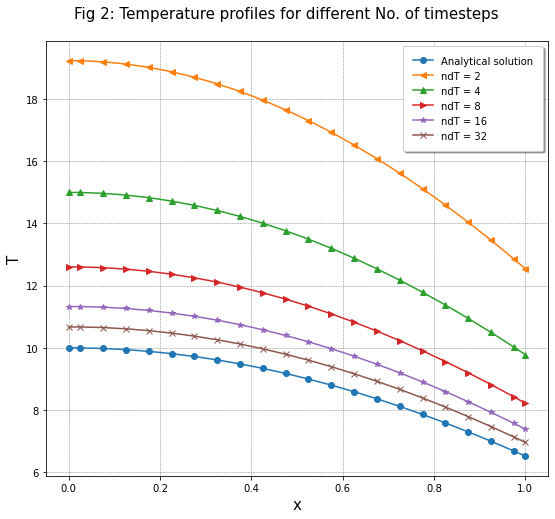

In [301]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize =(9,8))

plt.plot(xP,T_final_32,marker = "o",label = "Analytical solution")
plt.plot(xP, T_2 , marker = "<", label = "ndT = 2")
plt.plot(xP, T_4, marker = "^", label = "ndT = 4")
plt.plot(xP, T_8, marker = ">", label = "ndT = 8")
plt.plot(xP, T_16, marker = "*",label = "ndT = 16")
plt.plot(xP, T_32, marker = "x",label = "ndT = 32")

plt.xlabel('x',fontsize = 15)
plt.ylabel('T',fontsize = 15)
plt.suptitle('Fig 2: Temperature profiles for different No. of timesteps ', fontsize=15,y=0.94)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

## Plot of absolute average error vs timestep size

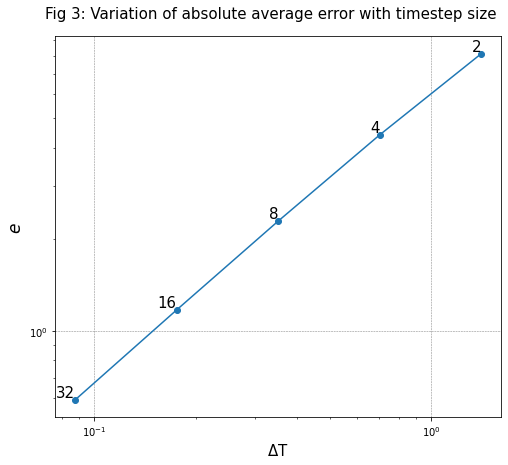

Order of Accuracy of the First order transient scheme = 1.299862919150922


In [302]:
""" Plot for testing temporal discretization error  """
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.figure(figsize =(8,7))

errors = [abs(e_2), abs(e_4), abs(e_8), abs(e_16),abs(e_32)]
timesteps = [dt2, dt4, dt8, dt16, dt32]

plt.loglog(timesteps, errors , marker = "o")

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)
# Fit the dummy exponential data
pars, cov = curve_fit(f=exponential, xdata=timesteps, ydata=errors, p0=[0, 0], bounds=(-np.inf, np.inf))
c = pars[1]
p = pars [-1]

plt.xlabel((r'$\Delta $T'),fontsize = 15)
plt.ylabel((r'$e$'),fontsize = 17)
plt.suptitle('Fig 3: Variation of absolute average error with timestep size', fontsize=15,y=0.94)
n = [2, 4, 8, 16, 32]

for i, txt in enumerate(n):
    plt.annotate(txt, (timesteps[i], errors[i]),fontsize=15, ha='right', va='bottom')

plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()
print('Order of Accuracy of the First order transient scheme =',p)

## Comments of error variation with timestep size

In $Fig.2$ we have plotted the temperature profile at final time (3.2632 second) over half of the plane wall (from x=0 to x=L) for different number of timesteps. It is observed that, the temperature profile for 32 timesteps with $\Delta $T = 0.087803 is the closest to the Analytical solution and the temperature profile for 2 timesteps with $\Delta $T = 1.40485 is the farthest. This indicates that, more the number of timesteps we use i.e. smaller the timestep size, better will be the accuracy of the solution.

In $Fig.3$, we have plotted the absolute average error vs the time step size for first order transient scheme and fitted an exponential curve on the log-log plot to obtain the exponent $p$ in $e$ = $c(\Delta T)^{p}$ as 1.29 which rounds to 1. Thus, our plot supports the conclusion that First order transient scheme is 1st order accurate .

## Plot of T(0,t2) vs Number of timesteps

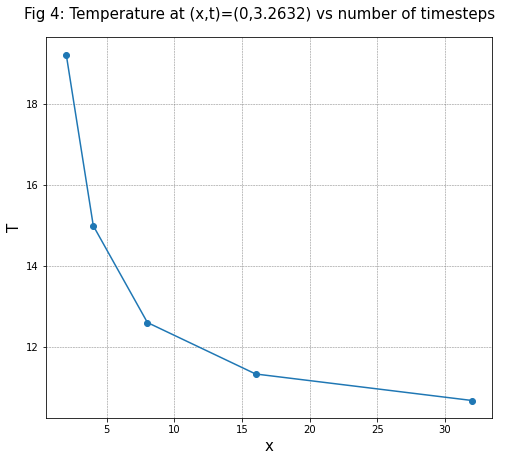

In [303]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize =(8,7))

xarray = [2,4,8,16,32]
yarray = [T_2[1],T_4[1],T_8[1],T_16[1],T_32[1] ]

plt.plot(xarray, yarray , marker = "o")

plt.xlabel('x',fontsize = 15)
plt.ylabel('T',fontsize = 15)
plt.suptitle('Fig 4: Temperature at (x,t)=(0,3.2632) vs number of timesteps ', fontsize=15,y=0.94)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

From the Analytical solution we know that at x=0 at the final timestep i.e. $t_{2}$ = 3.2632 second, the temperature should be 10 [$^\circ$C]. When we divide the time interval into 2 timesteps only, then we obtaint T(0,$t_{2}$) = 19.22 [$^\circ$C]. Then as we increase the number of timesteps to 4,8,16 and finally 32 we get T(0,$t_{2}$) = 14.993, 12.599, 11.326 and 10.67 [$^\circ$C] respectively. Thus when the time interval is divided into 32 timesteps, the temperature at the centerline of the plane wall at the end of simulation is closest to the analytical temperature. 